## A gentle introduction to the DataFrames.jl package

[Bogumił Kamiński](http://bogumilkaminski.pl/about/)

This is a hands-on tutorial and does not intend to cover the details of the internals.

Also we do not try to achieve maximum performance, but show how one can simply do typical tasks.

### The packages used in the tutorial

installed packages

In [1]:
using DataFrames        # core package
using CSV               # working with CSV files
using FreqTables        # frequency tables
using Tables            # interfaces with other tabular types
using Plots, StatsPlots # plotting
using GLM               # regression models

┌ Info: Recompiling stale cache file C:\Users\bogum\.julia\compiled\v1.1\CSV\HHBkp.ji for CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file C:\Users\bogum\.julia\compiled\v1.1\GLM\6OREG.ji for GLM [38e38edf-8417-5370-95a0-9cbb8c7f171a]
└ @ Base loading.jl:1184


in-built modules

In [2]:
using Statistics, Serialization

Let us make sure we use the same versions of the packages.

In [3]:
using Pkg

In [4]:
versions = [(name=pkg, version=Pkg.installed()[pkg])
            for pkg in ["DataFrames", "CSV", "FreqTables", "Tables", "Plots", "StatsPlots", "GLM"]]

7-element Array{NamedTuple{(:name, :version),Tuple{String,VersionNumber}},1}:
 (name = "DataFrames", version = v"0.18.3")
 (name = "CSV", version = v"0.5.5")        
 (name = "FreqTables", version = v"0.3.1") 
 (name = "Tables", version = v"0.2.4")     
 (name = "Plots", version = v"0.25.1")     
 (name = "StatsPlots", version = v"0.11.0")
 (name = "GLM", version = v"1.1.1")        

It is time for a first encounter with a `DataFrame`

In [5]:
versions_df = DataFrame(versions)

,name,version
,String,VersionN…
1,DataFrames,"v""0.18.3"""
2,CSV,"v""0.5.5"""
3,FreqTables,"v""0.3.1"""
4,Tables,"v""0.2.4"""
5,Plots,"v""0.25.1"""
6,StatsPlots,"v""0.11.0"""
7,GLM,"v""1.1.1"""


Let us play with it a bit - just to get a feeling. First grab one column from it.

In [6]:
versions_df.name, versions_df[:name], versions_df[1]

(["DataFrames", "CSV", "FreqTables", "Tables", "Plots", "StatsPlots", "GLM"], ["DataFrames", "CSV", "FreqTables", "Tables", "Plots", "StatsPlots", "GLM"], ["DataFrames", "CSV", "FreqTables", "Tables", "Plots", "StatsPlots", "GLM"])

Now grab one row.

In [7]:
versions_df[1, :]

,name,version
,String,VersionN…
1,DataFrames,"v""0.18.3"""


Some people like to work with `NamedTuple`s

In [8]:
copy(versions_df[1, :])

(name = "DataFrames", version = v"0.18.3")

Now we want to get a single entry. We do it in three ways again (just to get comfortable).

In [9]:
versions_df[1, 2], versions_df.version[1], versions_df[1, :version]

(v"0.18.3", v"0.18.3", v"0.18.3")

You can also convert your data frame into a `Matrix` (this is most useful when you have numeric data only)

In [10]:
Matrix(versions_df)

7×2 Array{Any,2}:
 "DataFrames"  v"0.18.3"
 "CSV"         v"0.5.5" 
 "FreqTables"  v"0.3.1" 
 "Tables"      v"0.2.4" 
 "Plots"       v"0.25.1"
 "StatsPlots"  v"0.11.0"
 "GLM"         v"1.1.1" 

### Reading in a basic CSV file

Most likely you will want to read in the data from some external source, and typically (like it or not) it will be a CSV file.

We will work with data described and provided [here](https://archive.ics.uci.edu/ml/datasets/bank+marketing). I have included the source file in the repository of the tutorial to simplify things.

In [11]:
bank = DataFrame(CSV.File("bank-additional-full.csv"))

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
,Int64,String,String,String,String,String,String,String,String,String,Int64,Int64,Int64,Int64,String,Float64,Float64,Float64,Float64,Float64,String
1,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
5,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,198,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
7,59,admin.,married,professional.course,no,no,no,telephone,may,mon,139,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
8,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,217,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
9,24,technician,single,professional.course,no,yes,no,telephone,may,mon,380,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


If you see a different number of rows/columns printed do not panic. You can adjust it following the instructions [here](https://juliadata.github.io/DataFrames.jl/latest/man/getting_started.html#Installation-1).

Some useful facts are that when displaying a data frame you get an information about its size on top and element types contained in its columns just under column names.

It is equally easy to save the data frame back to a CSV file.

In [12]:
CSV.write("newfile.txt", bank)

"newfile.txt"

Let us make sure that all is saved correctly.

In [13]:
DataFrame(CSV.File("newfile.txt")) == bank

true

The beauty of the CSV.jl package is that it does autodetection of delimiters. Actually the original file used `;` while our newly created file used `,` (we could change this but `,` stantds for C in CSV so this is the default). Below we inspect both files visually.

In [14]:
readlines("bank-additional-full.csv")[1:3]

3-element Array{String,1}:
 "\"age\";\"job\";\"marital\";\"education\";\"default\";\"housing\";\"loan\";\"contact\";\"month\";\"day_of_week\";\"duration\";\"campaign\";\"pdays\";\"previous\";\"poutcome\";\"emp.var.rate\";\"cons.price.idx\";\"cons.conf.idx\";\"euribor3m\";\"nr.employed\";\"y\""
 "56;\"housemaid\";\"married\";\"basic.4y\";\"no\";\"no\";\"no\";\"telephone\";\"may\";\"mon\";261;1;999;0;\"nonexistent\";1.1;93.994;-36.4;4.857;5191;\"no\""                                                                                                             
 "57;\"services\";\"married\";\"high.school\";\"unknown\";\"no\";\"no\";\"telephone\";\"may\";\"mon\";149;1;999;0;\"nonexistent\";1.1;93.994;-36.4;4.857;5191;\"no\""                                                                                                      

In [15]:
readlines("newfile.txt")[1:3]

3-element Array{String,1}:
 "age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y"
 "56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no"                                                                     
 "57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no"                                                              

We will not need `newfile.txt` so let us remove it.

In [16]:
rm("newfile.txt")

### Your first steps with `DataFrame`

Jou can get a list of names in a data frame using the `names` function.

In [17]:
names(bank)

21-element Array{Symbol,1}:
 :age                    
 :job                    
 :marital                
 :education              
 :default                
 :housing                
 :loan                   
 :contact                
 :month                  
 :day_of_week            
 ⋮                       
 :pdays                  
 :previous               
 :poutcome               
 Symbol("emp.var.rate")  
 Symbol("cons.price.idx")
 Symbol("cons.conf.idx") 
 :euribor3m              
 Symbol("nr.employed")   
 :y                      

The strange looking `Symbol` entries inform you that the column name was non-standard (contained a `.` in this case). You cannot use `.` access to such columns unfortunately, but have to use "bracket" syntax or pass a column number.

In [18]:
bank[Symbol("cons.conf.idx")]

41188-element Array{Float64,1}:
 -36.4
 -36.4
 -36.4
 -36.4
 -36.4
 -36.4
 -36.4
 -36.4
 -36.4
 -36.4
   ⋮  
 -50.8
 -50.8
 -50.8
 -50.8
 -50.8
 -50.8
 -50.8
 -50.8
 -50.8

Our data frame looks a bit large. Let us subset it.

In [19]:
bank2 = select(bank, [:y, :age, :campaign, :pdays])

,y,age,campaign,pdays
,String,Int64,Int64,Int64
1,no,56,1,999
2,no,57,1,999
3,no,37,1,999
4,no,40,1,999
5,no,56,1,999
6,no,45,1,999
7,no,59,1,999
8,no,41,1,999
9,no,24,1,999


There is some strange `999` value in the last column. Let us investigate this.

In [20]:
describe(bank2)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Nothing,DataType
1,y,,no,,yes,2,,String
2,age,40.0241,17,38.0,98,,,Int64
3,campaign,2.56759,1,2.0,56,,,Int64
4,pdays,962.475,0,999.0,999,,,Int64


(notice that the result is also a data frame, so you can work with it programatically in the future if you want)

In [21]:
freqtable(bank2, :pdays)

27-element Named Array{Int64,1}
pdays  │ 
───────┼──────
0      │    15
1      │    26
2      │    61
3      │   439
4      │   118
5      │    46
6      │   412
7      │    60
8      │    18
⋮            ⋮
18     │     7
19     │     3
20     │     1
21     │     2
22     │     3
25     │     1
26     │     1
27     │     1
999    │ 39673

In [22]:
prop(freqtable(bank2, :pdays))

27-element Named Array{Float64,1}
pdays  │ 
───────┼────────────
0      │ 0.000364184
1      │ 0.000631252
2      │  0.00148101
3      │   0.0106584
4      │  0.00286491
5      │  0.00111683
6      │   0.0100029
7      │  0.00145673
8      │  0.00043702
⋮                  ⋮
18     │ 0.000169952
19     │  7.28367e-5
20     │  2.42789e-5
21     │  4.85578e-5
22     │  7.28367e-5
25     │  2.42789e-5
26     │  2.42789e-5
27     │  2.42789e-5
999    │    0.963217

It turns out that `999` means that the client was never contacted by a bank before (see https://archive.ics.uci.edu/ml/datasets/bank+marketing for a description of the data set)

Assume we want to work only with customers who were contacted previously. We can filter `bank2` data frame in place.

In [23]:
bank3 = filter(row -> row.pdays != 999, bank2)

,y,age,campaign,pdays
,String,Int64,Int64,Int64
1,no,37,1,6
2,no,48,1,4
3,no,42,1,4
4,no,50,1,3
5,no,36,2,4
6,yes,32,2,5
7,no,31,1,5
8,no,51,2,1
9,no,52,1,6


One might ask if the data is correlated in this data frame. It is easy to check.

And recode variable `y` to be binary. Let us first make sure that it is binary indeed.

In [24]:
by(bank3, :y, count = :y=>length)

,y,count
,String,Int64
1,no,548
2,yes,967


OK - it is safe to recode it.

In [25]:
bank3.y_bin = recode(bank3.y, 0, "yes"=>1)

1515-element Array{Int64,1}:
 0
 0
 0
 0
 0
 1
 0
 0
 0
 0
 ⋮
 1
 1
 1
 0
 1
 1
 1
 1
 0

Always double check if you got what you wanted. We will do it in several ways.

In [26]:
freqtable(bank3, :y, :y_bin)

2×2 Named Array{Int64,2}
y ╲ y_bin │   0    1
──────────┼─────────
no        │ 548    0
yes       │   0  967

In [27]:
by(bank3, [:y, :y_bin], df -> (count=nrow(df),))

,y,y_bin,count
,String,Int64,Int64
1,no,0,548
2,yes,1,967


In [28]:
by(bank3, :y, df -> (y_bin_0 = count(==(0), df.y_bin), y_bin_1 = count(==(1), df.y_bin)))

,y,y_bin_0,y_bin_1
,String,Int64,Int64
1,no,548,0
2,yes,0,967


In [29]:
crosstable = by(bank3, :y, df -> DataFrame([[count(==(i), df.y_bin)] for i in 0:1], Symbol.(0:1)))

,y,0,1
,String,Int64,Int64
1,no,548,0
2,yes,0,967


Let us try getting something similar we got in the first approach

In [30]:
crosstable2 = stack(crosstable, 2:3)

,variable,value,y
,Symbol,Int64,String
1,0,548,no
2,0,0,yes
3,1,0,no
4,1,967,yes


What if we do not like the ordering and naming of variables in this table?

In [31]:
rename!(crosstable2, :variable=>:y_bin, :value=>:count)

,y_bin,count,y
,Symbol,Int64,String
1,0,548,no
2,0,0,yes
3,1,0,no
4,1,967,yes


In [32]:
permutecols!(crosstable2, [3,1,2])

,y,y_bin,count
,String,Symbol,Int64
1,no,0,548
2,yes,0,0
3,no,1,0
4,yes,1,967


In [33]:
sort!(crosstable2)

,y,y_bin,count
,String,Symbol,Int64
1,no,0,548
2,no,1,0
3,yes,0,0
4,yes,1,967


In [34]:
crosstable2.y_bin = parse.(Int, string.(crosstable2.y_bin))

4-element Array{Int64,1}:
 0
 1
 0
 1

In [35]:
filter(row -> row.count != 0,crosstable2)

,y,y_bin,count
,String,Int64,Int64
1,no,0,548
2,yes,1,967


back to the correlation analysis ...

In [36]:
cor(Matrix(bank3[2:end]))

4×4 Array{Float64,2}:
  1.0          0.00495337  -0.069608    0.0702834
  0.00495337   1.0          0.0457519  -0.125418 
 -0.069608     0.0457519    1.0        -0.0352235
  0.0702834   -0.125418    -0.0352235   1.0      

In [37]:
cor2 = DataFrame([(var1=names(bank3)[i],
                   var2=names(bank3)[j],
                   cor=cor(bank3[i], bank3[j])) for i in 2:ncol(bank3) for j in 2:ncol(bank3)])

,var1,var2,cor
,Symbol,Symbol,Float64
1,age,age,1.0
2,age,campaign,0.00495337
3,age,pdays,-0.069608
4,age,y_bin,0.0702834
5,campaign,age,0.00495337
6,campaign,campaign,1.0
7,campaign,pdays,0.0457519
8,campaign,y_bin,-0.125418
9,pdays,age,-0.069608


In [38]:
unstack(cor2, :var2, :cor)

,var1,age,campaign,pdays,y_bin
,Symbol,Float64⍰,Float64⍰,Float64⍰,Float64⍰
1,age,1.0,0.00495337,-0.069608,0.0702834
2,campaign,0.00495337,1.0,0.0457519,-0.125418
3,pdays,-0.069608,0.0457519,1.0,-0.0352235
4,y_bin,0.0702834,-0.125418,-0.0352235,1.0


### Using `DataFrame` for dynamic collection of data

Let us play a game. We draw a random numbers from U(0,1) until their sum exceeds `1`. We want to store the results of such experiment in a `DataFrame`.

In [39]:
function run_experiment()
    draws = Float64[]
    while true
        push!(draws, rand())
        sum(draws) > 1 && return (draws=draws, count=length(draws))
    end
end

run_experiment (generic function with 1 method)

In [40]:
run_experiment()

(draws = [0.875284, 0.2806], count = 2)

In [41]:
df = DataFrame()

""
""


In [42]:
push!(df, run_experiment())

,draws,count
,Array…,Int64
1,"[0.910343, 0.094289]",2


In [43]:
foreach(_ -> push!(df, run_experiment()), 1:99999)

In [44]:
df

,draws,count
,Array…,Int64
1,"[0.910343, 0.094289]",2
2,"[0.119128, 0.899693]",2
3,"[0.562052, 0.581186]",2
4,"[0.772959, 0.0271796, 0.103931, 0.697509]",4
5,"[0.427945, 0.10637, 0.736755]",3
6,"[0.018253, 0.334346, 0.883985]",3
7,"[0.069451, 0.107354, 0.879877]",3
8,"[0.125514, 0.341374, 0.482092, 0.300086]",4
9,"[0.227408, 0.624079, 0.862773]",3


In [45]:
mean(df[2])

2.7156

In [46]:
mean(row.draws[1] for row in eachrow(df))

0.5003574899315915

In [47]:
mean(v[end] for v in df[1])

0.640479890798387

Sometimes it is useful to convert a DataFrame into a `NamedTuple` of vectors

In [48]:
Tables.columntable(df)

(draws = Array{Float64,1}[[0.910343, 0.094289], [0.119128, 0.899693], [0.562052, 0.581186], [0.772959, 0.0271796, 0.103931, 0.697509], [0.427945, 0.10637, 0.736755], [0.018253, 0.334346, 0.883985], [0.069451, 0.107354, 0.879877], [0.125514, 0.341374, 0.482092, 0.300086], [0.227408, 0.624079, 0.862773], [0.874588, 0.38932]  …  [0.299982, 0.0652485, 0.759492], [0.670265, 0.674408], [0.0597476, 0.400727, 0.276688, 0.273126], [0.105552, 0.0784286, 0.580276, 0.140634, 0.300507], [0.241579, 0.431582, 0.426776], [0.818822, 0.800074], [0.575013, 0.0949803, 0.340526], [0.0612906, 0.14682, 0.936358], [0.481141, 0.281153, 0.572309], [0.257063, 0.751436]], count = [2, 2, 2, 4, 3, 3, 3, 4, 3, 2  …  3, 2, 4, 5, 3, 2, 3, 3, 3, 2])

or a vector of `NamedTuple`s

In [49]:
Tables.rowtable(df)

100000-element Array{NamedTuple{(:draws, :count),Tuple{Array{Float64,1},Int64}},1}:
 (draws = [0.910343, 0.094289], count = 2)                               
 (draws = [0.119128, 0.899693], count = 2)                               
 (draws = [0.562052, 0.581186], count = 2)                               
 (draws = [0.772959, 0.0271796, 0.103931, 0.697509], count = 4)          
 (draws = [0.427945, 0.10637, 0.736755], count = 3)                      
 (draws = [0.018253, 0.334346, 0.883985], count = 3)                     
 (draws = [0.069451, 0.107354, 0.879877], count = 3)                     
 (draws = [0.125514, 0.341374, 0.482092, 0.300086], count = 4)           
 (draws = [0.227408, 0.624079, 0.862773], count = 3)                     
 (draws = [0.874588, 0.38932], count = 2)                                
 ⋮                                                                       
 (draws = [0.670265, 0.674408], count = 2)                               
 (draws = [0.0597476, 0.4007

Also if you have a non-standard data types stored in your data frame CSV is not flexible enough to safely store it on disk.

In such case the simplest option is to use serialization. This is a fast and safe approach. Its only drawback is that it assumes that the data will be read on the same configuration of the machine, Julia and the packages as it were written (this is a low level binary representation of your data).

In [50]:
serialize("df.bin", df)

In [51]:
df2 = deserialize("df.bin")

,draws,count
,Array…,Int64
1,"[0.910343, 0.094289]",2
2,"[0.119128, 0.899693]",2
3,"[0.562052, 0.581186]",2
4,"[0.772959, 0.0271796, 0.103931, 0.697509]",4
5,"[0.427945, 0.10637, 0.736755]",3
6,"[0.018253, 0.334346, 0.883985]",3
7,"[0.069451, 0.107354, 0.879877]",3
8,"[0.125514, 0.341374, 0.482092, 0.300086]",4
9,"[0.227408, 0.624079, 0.862773]",3


In [52]:
df2 == df

true

In [53]:
rm("df.bin")

## Handling missing data

Let us go back to our `bank2` data frame.

In [54]:
bank2

,y,age,campaign,pdays
,String,Int64,Int64,Int64
1,no,56,1,999
2,no,57,1,999
3,no,37,1,999
4,no,40,1,999
5,no,56,1,999
6,no,45,1,999
7,no,59,1,999
8,no,41,1,999
9,no,24,1,999


We know that if `:pdays` is `999` then it is a missing value. We can perform the conversion in several ways.

In [55]:
bank2.pdays2 = replace(bank2.pdays, 999=>missing)

41188-element Array{Union{Missing, Int64},1}:
  missing
  missing
  missing
  missing
  missing
  missing
  missing
  missing
  missing
  missing
 ⋮       
  missing
  missing
  missing
 9       
  missing
  missing
  missing
  missing
  missing

In [56]:
freqtable(bank2.pdays .!= 999, bank2.pdays2 .!= missing)

2×1 Named Array{Int64,2}
Dim1 ╲ Dim2 │ missing
────────────┼────────
false       │   39673
true        │    1515

This is surprising. We can to better

In [57]:
freqtable(bank2.pdays .!= 999, isequal.(bank2.pdays2, missing))

2×2 Named Array{Int64,2}
Dim1 ╲ Dim2 │ false   true
────────────┼─────────────
false       │     0  39673
true        │  1515      0

Remember that `missing` usses three valued logic. The `isequal` and `isless` functions do not pass missing, other standard operators return missing if they encounter missing.

In [58]:
1 < missing

missing

In [59]:
isless(1, missing)

true

In [60]:
isless(Inf, missing)

true

by the way, remember that `missing` is larger than any real value in `isless` comparison.

Let us see another example to see that it matters.

In [61]:
filter(row -> row.pdays2 == 1, bank2)

TypeError: TypeError: non-boolean (Missing) used in boolean context

It is easy to fix it though.

In [62]:
filter(row -> isequal(row.pdays2, 1), bank2)

,y,age,campaign,pdays,pdays2
,String,Int64,Int64,Int64,Int64⍰
1,no,51,2,1,1
2,no,50,3,1,1
3,no,26,1,1,1
4,no,34,1,1,1
5,no,37,2,1,1
6,no,45,1,1,1
7,no,48,2,1,1
8,no,27,1,1,1
9,yes,32,4,1,1


Sometimes you want to retain `missing` after filtering. This is the way to do it.

In [63]:
bank_tmp = filter(row -> coalesce(row.pdays2 == 1, true), bank2)

,y,age,campaign,pdays,pdays2
,String,Int64,Int64,Int64,Int64⍰
1,no,56,1,999,missing
2,no,57,1,999,missing
3,no,37,1,999,missing
4,no,40,1,999,missing
5,no,56,1,999,missing
6,no,45,1,999,missing
7,no,59,1,999,missing
8,no,41,1,999,missing
9,no,24,1,999,missing


But the table is long - how to make sure we have only `1` and `missing` in the `:pdays2` column?

In [64]:
freqtable(bank_tmp, :pdays2)

2-element Named Array{Int64,1}
pdays2  │ 
────────┼──────
1       │    26
missing │ 39673

In [65]:
by(bank_tmp, :pdays2, nrow)

,pdays2,x1
,Int64⍰,Int64
1,missing,39673
2,1,26


Note that columns allowing missing values have a special `⍰` character printed by their element type information.

Also `describe` is useful in analyzing missing data.

In [66]:
describe(bank2)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Union…,DataType
1,y,,no,,yes,2,,String
2,age,40.0241,17,38.0,98,,,Int64
3,campaign,2.56759,1,2.0,56,,,Int64
4,pdays,962.475,0,999.0,999,,,Int64
5,pdays2,6.01452,0,6.0,27,,39673,Int64


What if we wanted to change `:pdays` vector to allow missing values?

Initially it does not allow them.

In [67]:
bank2.pdays[1] = missing

MethodError: MethodError: Cannot `convert` an object of type Missing to an object of type Int64
Closest candidates are:
  convert(::Type{T<:Number}, !Matched::T<:Number) where T<:Number at number.jl:6
  convert(::Type{T<:Number}, !Matched::Number) where T<:Number at number.jl:7
  convert(::Type{T<:Integer}, !Matched::Ptr) where T<:Integer at pointer.jl:23
  ...

You have to change the type of the vector using the `allowmissing!` function.

In [68]:
allowmissing!(bank2, :pdays)

,y,age,campaign,pdays,pdays2
,String,Int64,Int64,Int64⍰,Int64⍰
1,no,56,1,999,missing
2,no,57,1,999,missing
3,no,37,1,999,missing
4,no,40,1,999,missing
5,no,56,1,999,missing
6,no,45,1,999,missing
7,no,59,1,999,missing
8,no,41,1,999,missing
9,no,24,1,999,missing


Now you can assign `missing` to `:pdays` column.

In [69]:
replace!(bank2.pdays, 999 => missing)

41188-element Array{Union{Missing, Int64},1}:
  missing
  missing
  missing
  missing
  missing
  missing
  missing
  missing
  missing
  missing
 ⋮       
  missing
  missing
  missing
 9       
  missing
  missing
  missing
  missing
  missing

In [70]:
describe(bank2)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Union…,DataType
1,y,,no,,yes,2,,String
2,age,40.0241,17,38.0,98,,,Int64
3,campaign,2.56759,1,2.0,56,,,Int64
4,pdays,6.01452,0,6.0,27,,39673,Int64
5,pdays2,6.01452,0,6.0,27,,39673,Int64


Again - let us check that it worked correctly.

In [71]:
bank2.pdays == bank2.pdays2

missing

We knew it would fail - right?

In [72]:
isequal(bank2.pdays, bank2.pdays2)

true

Often we want to get rid of missing data from a data frame. We can do this using the `dropmissing` function.

In [73]:
bank4 = dropmissing(bank2)

,y,age,campaign,pdays,pdays2
,String,Int64,Int64,Int64,Int64
1,no,37,1,6,6
2,no,48,1,4,4
3,no,42,1,4,4
4,no,50,1,3,3
5,no,36,2,4,4
6,yes,32,2,5,5
7,no,31,1,5,5
8,no,51,2,1,1
9,no,52,1,6,6


Note that now columns automatically dicallow missing values.

Actually `bank4` should be the same as `bank3` on the first 4 columns. Let us check this.

In [74]:
bank3[1:4] == bank4[1:4]

true

## No tutorial is complete without plotting instructions

Let us first do some exploratory plotting

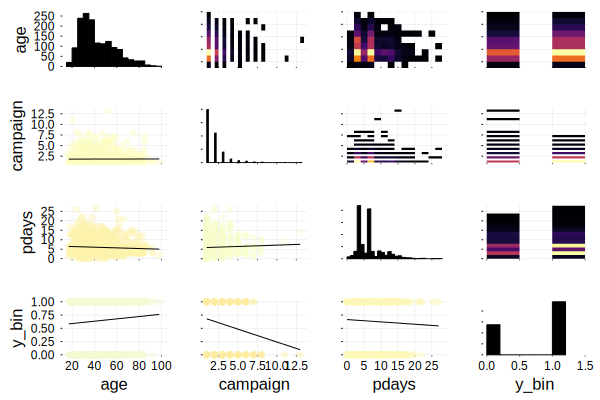

In [75]:
@df bank3 corrplot(cols(2:5))

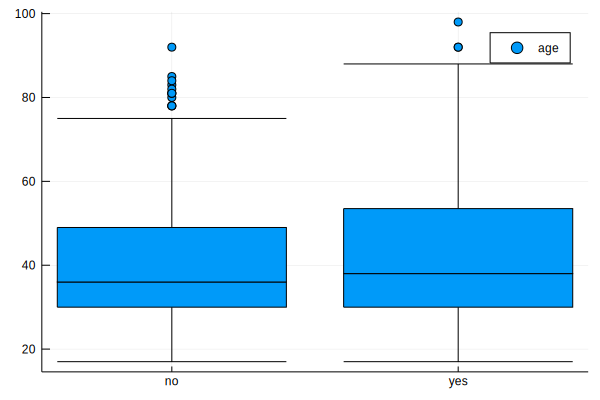

In [76]:
@df bank3 boxplot(:y, :age, label="age")

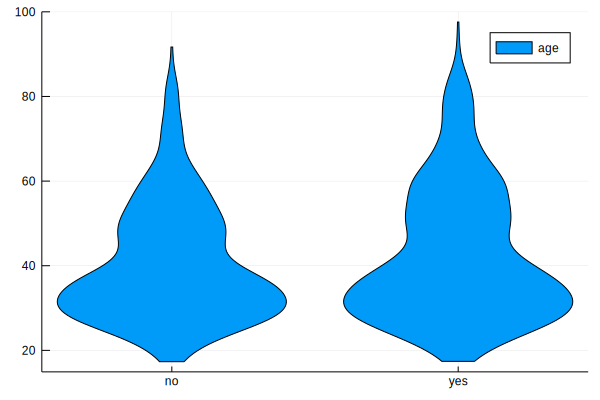

In [77]:
@df bank3 violin(:y, :age, label="age")

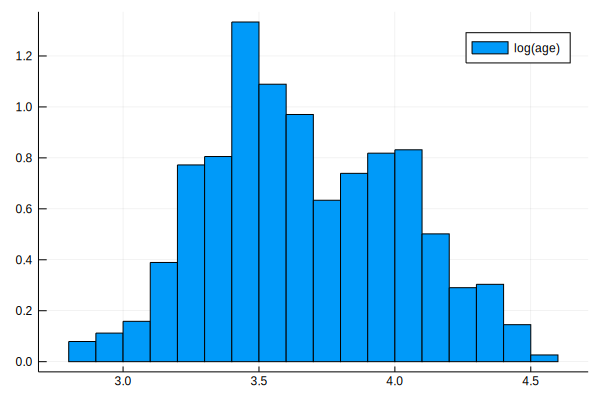

In [78]:
@df bank3 histogram(log.(:age), label="log(age)", normalize=true)

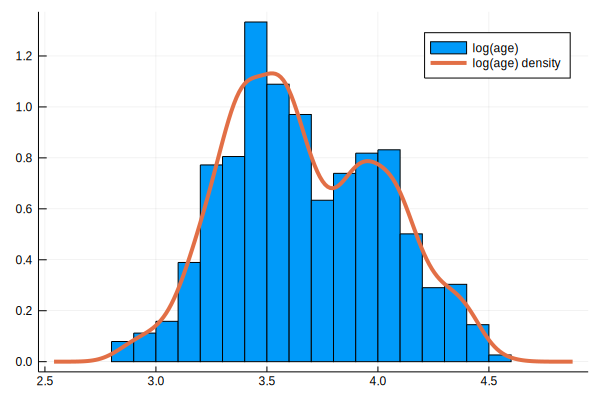

In [79]:
@df bank3 density!(log.(:age), linewidth=4, label="log(age) density")

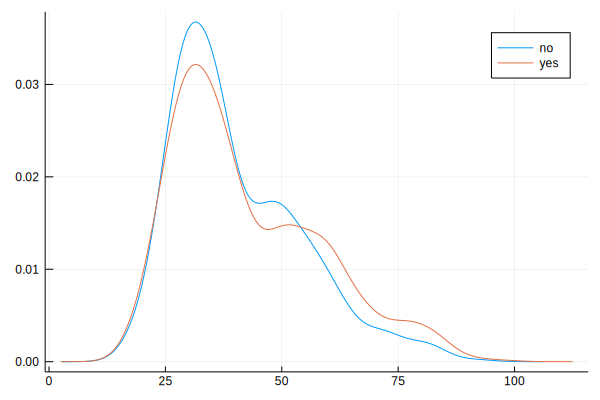

In [80]:
@df bank3 density(:age, group=:y)

## Categorical vairables

Sometimes you want to add to your columns the metadata that they are categorical.

In this section we discuss how you can do it and how this information is used by the `GLM` package as an application example.

Let us get back to our original `bank` data frame. We will want to build a model explaining `:y` using some other variables from the data set.

In [81]:
glm(@formula(y ~ age + day_of_week + campaign), bank, Binomial())

MethodError: MethodError: no method matching zero(::Type{String})
Closest candidates are:
  zero(!Matched::Type{LibGit2.GitHash}) at C:\cygwin\home\Administrator\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.1\LibGit2\src\oid.jl:220
  zero(!Matched::Type{Pkg.Resolve.VersionWeights.VersionWeight}) at C:\cygwin\home\Administrator\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.1\Pkg\src\resolve\VersionWeights.jl:19
  zero(!Matched::Type{Pkg.Resolve.MaxSum.FieldValues.FieldValue}) at C:\cygwin\home\Administrator\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.1\Pkg\src\resolve\FieldValues.jl:44
  ...

This failed, because the `GLM` package needs to know that `:y` is binary. Let us change this.

In [82]:
bank.y_bin = ifelse.(bank.y .== "yes", 1, 0)

41188-element Array{Int64,1}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 0
 0
 1
 0
 1
 0
 0
 1
 0

In [83]:
bank

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,y_bin
,Int64,String,String,String,String,String,String,String,String,String,Int64,Int64,Int64,Int64,String,Float64,Float64,Float64,Float64,Float64,String,Int64
1,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
2,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
3,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
4,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
5,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
6,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,198,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
7,59,admin.,married,professional.course,no,no,no,telephone,may,mon,139,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
8,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,217,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
9,24,technician,single,professional.course,no,yes,no,telephone,may,mon,380,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0


In [84]:
glm(@formula(y_bin ~ age + day_of_week + campaign), bank, Binomial())

StatsModels.DataFrameRegressionModel{GeneralizedLinearModel{GlmResp{Array{Float64,1},Binomial{Float64},LogitLink},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: y_bin ~ 1 + age + day_of_week + campaign

Coefficients:
──────────────────────────────────────────────────────────────
                     Estimate   Std.Error    z value  Pr(>|z|)
──────────────────────────────────────────────────────────────
(Intercept)       -2.18369     0.0727297   -30.0247     <1e-99
age                0.00916394  0.0014537     6.30389    <1e-9 
day_of_week: mon  -0.0986672   0.0514918    -1.91617    0.0553
day_of_week: thu   0.115643    0.0493282     2.34435    0.0191
day_of_week: tue   0.0670772   0.0503273     1.33282    0.1826
day_of_week: wed   0.0672455   0.0503671     1.33511    0.1818
campaign          -0.123559    0.00914756  -13.5073     <1e-40
──────────────────────────────────────────────────────────────

This is not very nice as `day_of_week` is not properly ordered. Fortunately it is easy to change this.

In [85]:
categorical!(bank, :day_of_week)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,y_bin
,Int64,String,String,String,String,String,String,String,String,Categorical…,Int64,Int64,Int64,Int64,String,Float64,Float64,Float64,Float64,Float64,String,Int64
1,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
2,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
3,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
4,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
5,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
6,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,198,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
7,59,admin.,married,professional.course,no,no,no,telephone,may,mon,139,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
8,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,217,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
9,24,technician,single,professional.course,no,yes,no,telephone,may,mon,380,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0


In [86]:
levels(bank.day_of_week)

5-element Array{String,1}:
 "fri"
 "mon"
 "thu"
 "tue"
 "wed"

In [87]:
levels!(bank.day_of_week, ["mon", "tue", "wed", "thu", "fri"]);

Now the order of levels should be correct.

In [88]:
glm(@formula(y_bin ~ age + day_of_week + campaign), bank, Binomial())

StatsModels.DataFrameRegressionModel{GeneralizedLinearModel{GlmResp{Array{Float64,1},Binomial{Float64},LogitLink},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: y_bin ~ 1 + age + day_of_week + campaign

Coefficients:
──────────────────────────────────────────────────────────────
                     Estimate   Std.Error    z value  Pr(>|z|)
──────────────────────────────────────────────────────────────
(Intercept)       -2.28236     0.0728343   -31.3363     <1e-99
age                0.00916394  0.0014537     6.30389    <1e-9 
day_of_week: tue   0.165744    0.0501678     3.3038     0.0010
day_of_week: wed   0.165913    0.0502154     3.30402    0.0010
day_of_week: thu   0.21431     0.0491724     4.35834    <1e-4 
day_of_week: fri   0.0986672   0.0514918     1.91617    0.0553
campaign          -0.123559    0.00914756  -13.5073     <1e-40
──────────────────────────────────────────────────────────────

Let us have a more detailed look at `:campaign` variable.

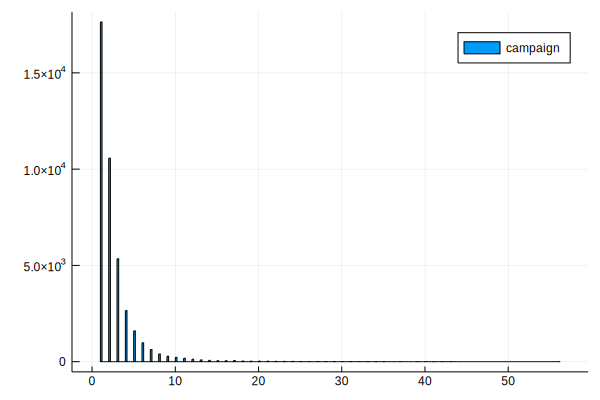

In [89]:
@df bank histogram(:campaign, label="campaign")

It is very skewed. We will cut it into several bins.

In [90]:
bank.campaign_cat = cut(bank.campaign, [1,2,3,4], extend=true)

41188-element CategoricalArray{String,1,UInt32}:
 "[1, 2)"
 "[1, 2)"
 "[1, 2)"
 "[1, 2)"
 "[1, 2)"
 "[1, 2)"
 "[1, 2)"
 "[1, 2)"
 "[1, 2)"
 "[1, 2)"
 ⋮       
 "[3, 4)"
 "[2, 3)"
 "[1, 2)"
 "[1, 2)"
 "[1, 2)"
 "[1, 2)"
 "[2, 3)"
 "[1, 2)"
 "[3, 4)"

In [91]:
levels(bank.campaign_cat)

4-element Array{String,1}:
 "[1, 2)" 
 "[2, 3)" 
 "[3, 4)" 
 "[4, 56]"

In [92]:
prop(freqtable(bank.campaign_cat))

4-element Named Array{Float64,1}
Dim1    │ 
────────┼─────────
[1, 2)  │ 0.428329
[2, 3)  │ 0.256628
[3, 4)  │ 0.129674
[4, 56] │  0.18537

In [93]:
glm(@formula(y_bin ~ age + day_of_week + campaign_cat), bank, Binomial())

StatsModels.DataFrameRegressionModel{GeneralizedLinearModel{GlmResp{Array{Float64,1},Binomial{Float64},LogitLink},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: y_bin ~ 1 + age + day_of_week + campaign_cat

Coefficients:
───────────────────────────────────────────────────────────────────
                          Estimate   Std.Error    z value  Pr(>|z|)
───────────────────────────────────────────────────────────────────
(Intercept)            -2.39969     0.0723434   -33.1708     <1e-99
age                     0.00912225  0.00145425    6.27282    <1e-9 
day_of_week: tue        0.16417     0.0502005     3.27028    0.0011
day_of_week: wed        0.162328    0.050238      3.23118    0.0012
day_of_week: thu        0.204475    0.0492072     4.15538    <1e-4 
day_of_week: fri        0.0941782   0.0514734     1.82965    0.0673
campaign_cat: [2, 3)   -0.137494    0.037935     -3.62445    0.0003
campaign_cat: [3, 4)   -0.202482    0.0496508

Now let us investigate the `:age` variable.

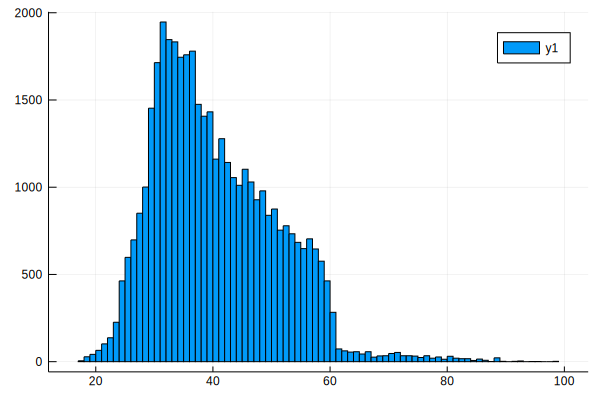

In [94]:
histogram(bank.age)

In [95]:
bank.age_cut = cut(bank.age, 10)

41188-element CategoricalArray{String,1,UInt32}:
 "[55.0, 98.0]"
 "[55.0, 98.0]"
 "[35.0, 38.0)"
 "[38.0, 41.0)"
 "[55.0, 98.0]"
 "[45.0, 49.0)"
 "[55.0, 98.0]"
 "[41.0, 45.0)"
 "[17.0, 28.0)"
 "[17.0, 28.0)"
 ⋮             
 "[55.0, 98.0]"
 "[35.0, 38.0)"
 "[35.0, 38.0)"
 "[28.0, 31.0)"
 "[55.0, 98.0]"
 "[45.0, 49.0)"
 "[55.0, 98.0]"
 "[41.0, 45.0)"
 "[55.0, 98.0]"

In [96]:
y_by_age = by(bank, :age_cut, mean_y_bin = :y_bin => mean)

,age_cut,mean_y_bin
,Categorical…,Float64
1,"[17.0, 28.0)",0.18196
2,"[28.0, 31.0)",0.129319
3,"[31.0, 33.0)",0.106512
4,"[33.0, 35.0)",0.110117
5,"[35.0, 38.0)",0.0913442
6,"[38.0, 41.0)",0.08525
7,"[41.0, 45.0)",0.0822559
8,"[45.0, 49.0)",0.0806931
9,"[49.0, 55.0)",0.0915523


In [97]:
using Plots.Measures # we need this to specify larger bottom margin in points

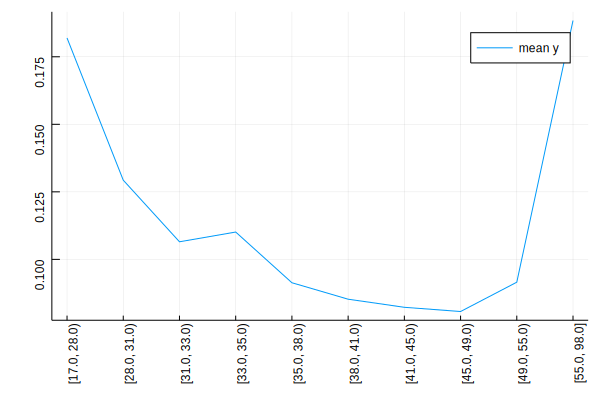

In [98]:
@df y_by_age plot(:age_cut, :mean_y_bin, label="mean y", rotation=90, bottom_margin=40pt)

It looks like our relationship is not linear. Let us add a quadratic term to the model.

In [99]:
bank.age2 = bank.age .^ 2 # this soon will be easier to do

41188-element Array{Int64,1}:
 3136
 3249
 1369
 1600
 3136
 2025
 3481
 1681
  576
  625
    ⋮
 4096
 1296
 1369
  841
 5329
 2116
 3136
 1936
 5476

In [100]:
model = glm(@formula(y_bin ~ age + age2 + day_of_week + campaign_cat), bank, Binomial())

StatsModels.DataFrameRegressionModel{GeneralizedLinearModel{GlmResp{Array{Float64,1},Binomial{Float64},LogitLink},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: y_bin ~ 1 + age + age2 + day_of_week + campaign_cat

Coefficients:
───────────────────────────────────────────────────────────────────
                          Estimate   Std.Error    z value  Pr(>|z|)
───────────────────────────────────────────────────────────────────
(Intercept)             1.90667     0.168144     11.3395     <1e-29
age                    -0.194612    0.00752238  -25.8711     <1e-99
age2                    0.00222718  8.16362e-5   27.2818     <1e-99
day_of_week: tue        0.146174    0.0510021     2.86603    0.0042
day_of_week: wed        0.132466    0.0510235     2.59618    0.0094
day_of_week: thu        0.183474    0.0498703     3.67903    0.0002
day_of_week: fri        0.0894965   0.0521378     1.71654    0.0861
campaign_cat: [2, 3)   -0.130879    0.

In [101]:
est = coef(model)

10-element Array{Float64,1}:
  1.9066724297220865   
 -0.19461243455868965  
  0.0022271825372772052
  0.14617362521031604  
  0.13246609237293744  
  0.1834744456304327   
  0.08949646535853148  
 -0.13087911994619206  
 -0.17296494557712722  
 -0.6097773077596923   

In [102]:
-est[2]/(2*est[3])

43.690274887977736

And we now see that the minimum probability is at age of around 44 years.